In [1]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import *
%load_ext autoreload
%autoreload 2
%matplotlib widget
mu = 0.1 
def convert_to_directed0(undirected_graph):
    # Create a new directed graph
    directed_graph = nx.DiGraph()

    # Define constant values for dynamic viscosity (mu)
 # Assumed for example purposes

    # Add edges to the directed graph with direction based on node label ordering
    for u, v, attr in undirected_graph.edges(data=True):
        if u < v:
            directed_graph.add_edge(u, v, **attr)
        else:
            directed_graph.add_edge(v, u, **attr)
    return directed_graph

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


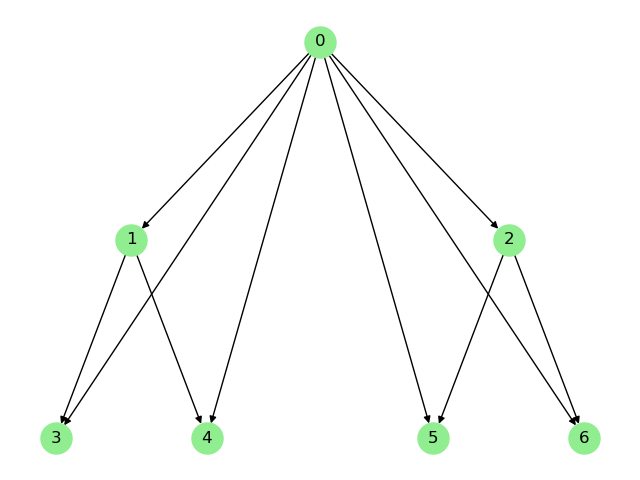

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Manually add nodes and edges for a binary tree
# Root node
root = 0
G.add_node(root)

# Level 1 nodes
level1_nodes = [1, 2]
for node in level1_nodes:
    G.add_edge(root, node,length=100,radius=2,v0=0)

# Level 2 nodes (leaves)
leaf_nodes = [3, 4, 5, 6]
connections = {1: [3, 4], 2: [5, 6]}  # Map parent nodes to their respective children
for parent, children in connections.items():
    for child in children:
        G.add_edge(parent, child,length=100,radius=2,v0=3)

visual_graph = G.copy()   
for leaf in leaf_nodes:
    G.add_edge(leaf, root,length=0,radius=2,v0=0)  # Add edge back to the root
visual_graph = convert_to_directed0(visual_graph)
G = convert_to_directed0(G)
for u, v, attr in G.edges(data=True):
    if (u,v) == (0,2):
        attr['v0'] = 3
    attr['Res'] = 8 * mu * attr["length"] / (np.pi * attr['radius']**4)
    attr['pot'] = -8 * mu * attr["length"]*attr['v0'] / (np.pi * attr['radius']**2)
visual_graph = convert_to_directed0(visual_graph)
G = convert_to_directed0(G)

# Define positions for the nodes to ensure the tree structure is clear
pos = {0: (0.5, 1), 
       1: (0.25, 0.6), 2: (0.75, 0.6),
       3: (0.15, 0.2), 4: (0.35, 0.2), 5: (0.65, 0.2), 6: (0.85, 0.2)}

# Draw the binary tree
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=500)
plt.title('Binary Tree with 4 Leaves')
plt.show()


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1999.67it/s]


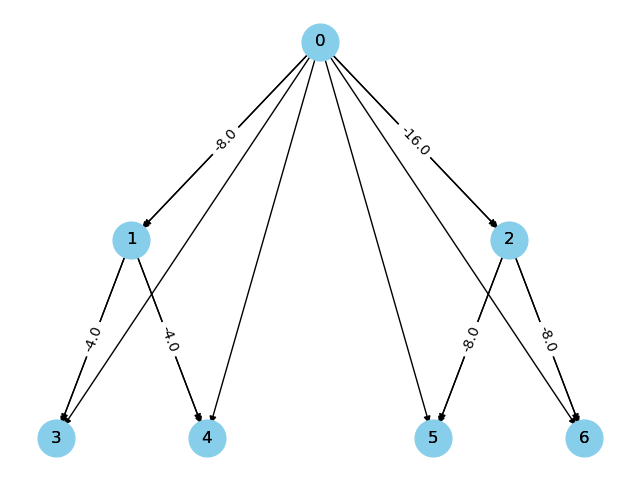

In [3]:
G = convert_to_directed0(G)
visual_graph = convert_to_directed0(visual_graph)
ext_flows = {}
A, b = build_matrix_system(G, ext_flows)
flows = solve_flows(A, b)


# Visualization with flow labels


# Use spring layout for other nodes
nx.draw_networkx(visual_graph, pos, node_size=700, node_color='skyblue', with_labels=True)

# Add flow labels to the edges
edge_labels = {edge: f"{flow:.1f}" for edge, flow in zip(G.edges(), flows)}
edge_labels = {edge: edge_labels[edge] for edge in visual_graph.edges()}

nx.draw_networkx_edge_labels(visual_graph, pos, edge_labels=edge_labels)
plt.title('Complex Pipe Network Flow')
plt.show()

In [4]:
DG = G.copy()
G = G.to_undirected()

In [5]:

edge_flows = {edge: flow for edge, flow in zip(DG.edges(), flows)}
nx.set_edge_attributes(G,edge_flows,"water_flux")
for u, v in G.edges():
    orientation = (1-2 * (u > v))  
    # orientation *= (2 * (G[u][v]['water_flux']>0)-1)
    if orientation>0:
        G[u][v]["QBC_p"] = G[u][v]['water_flux']  # Attribute for edge from A to B
        G[u][v]["QBC_m"] = 0  # Attribute for edge from A to B
    else:
        G[u][v]["QBC_m"] = G[u][v]['water_flux']
        G[u][v]["QBC_p"] = 0  #
for edge in G.edges:
    G[edge[0]][edge[1]]["QBC_net"] = G[edge[0]][edge[1]]["QBC_p"]-G[edge[0]][edge[1]]["QBC_m"]
    G[edge[0]][edge[1]]["QBC_tot"] = G[edge[0]][edge[1]]["QBC_p"]+G[edge[0]][edge[1]]["QBC_m"]

net_flux = {}
for node in G.nodes():
    G.edges(node)
    fluxes = [G[edge[0]][edge[1]]["water_flux"]*(1-2 * (edge[0] > edge[1]))  for edge in G.edges(node)]
    net_flux[node] = np.sum(fluxes)

In [6]:
fluxes = [G[edge[0]][edge[1]]["QBC_net"]*(2 * (edge[0] > edge[1])-1)  for edge in G.edges(2)]
fluxes

[-16.0, 8.0, 8.0]

In [7]:
net_flux

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}

In [19]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from amftrack.util.dbx import (upload
)
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,

)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from amftrack.transport.align_video_network import identify_nodes
logging.basicConfig(stream=sys.stdout, level=logging.debug)
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
mpl.rcParams["figure.dpi"] = 100
from amftrack.pipeline.functions.transport_processing.high_mag_videos.loading import load_video_dataset

from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
import networkx as nx
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\graphs"
plates = [
    "441_20230807", "449_20230807", "310_20230830"
]
plate_id = plates[0]
path_tot = os.path.join(path_root,f"graph{plate_id}.pickle")
spatial_temporal_graph,folders = load(path_tot)
exp = make_exp(spatial_temporal_graph,folders,make_pixel_list = True)


In [100]:
spatial_temporal_graph = simplify(spatial_temporal_graph)
fix_attributes(spatial_temporal_graph)
exp = make_exp(spatial_temporal_graph,folders)

91878
50


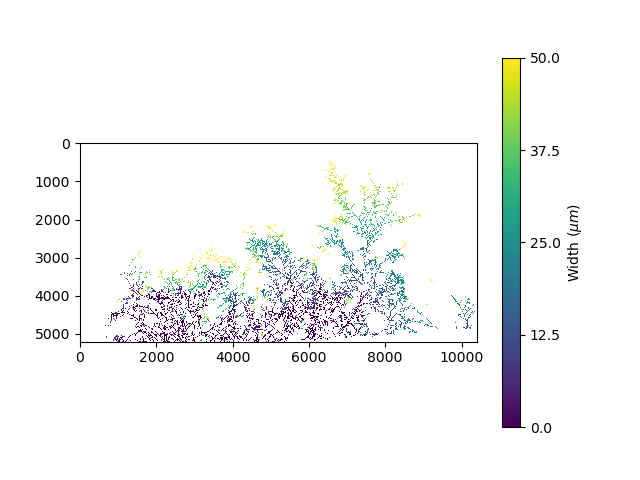

(<Figure size 640x480 with 2 Axes>, <AxesSubplot: >)

In [101]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 50
vmin = 0
t=0
# region = [[3750*5,5000*5],[5250*5,7500*5]]
region = [[0*5,0*5],[26000,52000]]

fig,ax = plt.subplots()
plot_edge_color_value(
    exp,
    t,
    lambda edge : edge.get_attribute("activation",t),
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    figax = (fig,ax),
    region = region
)


In [102]:
index0 = 35
index1 = 40

In [105]:
exp1 = add_fluxes(exp,index0,index1,folders,num_sinks = 20)


net_flow_heaton 3.552713678800501e-15
found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████| 2279/2279 [13:00<00:00,  2.92it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████| 2279/2279 [13:00<00:00,  2.92it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████| 2279/2279 [12:40<00:00,  3.00it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████| 2279/2279 [12:53<00:00,  2.95it/s]


net_flow_heaton 0
found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 3086.06it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 8970.71it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9007.10it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9002.80it/s]


net_flow_heaton 0
found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 8974.97it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9011.40it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9000.65it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9011.40it/s]


net_flow_heaton 0
found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 4499.25it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9612.61it/s]


found all cycles


Processing Cycles: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 8998.51it/s]


found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


net_flow_heaton 0
found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 2841.36it/s]


found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 4306.03it/s]


found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 8001.12it/s]


found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 7015.77it/s]


net_flow_heaton 0
found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 5145.12it/s]


found all cycles


Processing Cycles: 100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10029.42it/s]


found all cycles


Processing Cycles: 100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10005.50it/s]


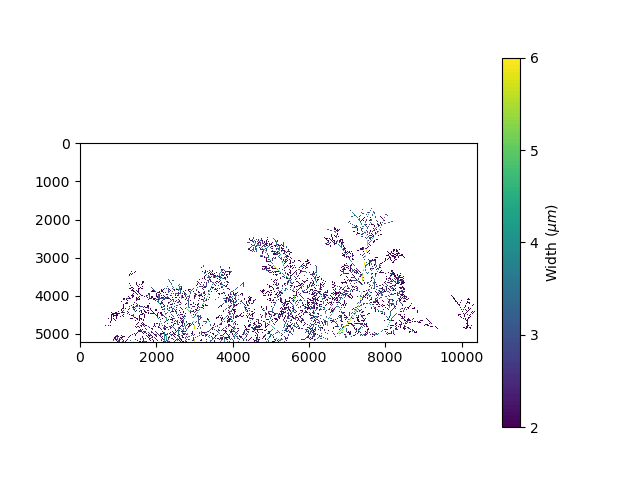

(<Figure size 640x480 with 2 Axes>, <AxesSubplot: >)

In [107]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm
attribute = "speed_backflow_phase"
vmax = 6
vmin = 2
t=0
# region = [[3750*5,5000*5],[5250*5,7500*5]]
region = [[0*5,0*5],[26000,52000]]

fig,ax = plt.subplots()
plot_edge_color_value(
    exp1,
    t,
    lambda edge : np.abs(edge.get_attribute(attribute,t)),
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    figax = (fig,ax),
    region = region
)


In [108]:
def plot_arrows_along_edge(ax, begin, end, color, spacing=60):
    # Calculate the vector and its magnitude
    vector = end - begin
    distance = np.linalg.norm(vector)
    unit_vector = vector / distance

    # Calculate the number of arrows to create based on the spacing
    num_arrows = int(distance / spacing)
    if num_arrows<2:
        spacing= distance/2
        num_arrows = 1
    # Plot each arrow along the edge
    for i in range(1, num_arrows + 1):
        point = begin + unit_vector * (i * spacing)
        ax.annotate('', xytext=(point[1], point[0]), xy=(point[1] + unit_vector[1], point[0] + unit_vector[0]),
                    arrowprops=dict(arrowstyle="->,head_length=0.2,head_width=0.1", color=color))
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

t=0
downsizing = 5
def plot_region(region):
    fig, ax,f = plot_edge_color_value_3(
        exp1,
        t,
        lambda edge : np.abs(exp1.nx_graph[0][edge.begin.label][edge.end.label][attribute])*C_factor_flux,
        cmap=cm.get_cmap("coolwarm", 100),
        plot_cmap=True,
        show_background=False,
        dilation=10,
        figsize=(6, 4),
        alpha = 1,
        downsizing = downsizing,
        region = region,
        v_min = -vmax,
        v_max = vmax
    )
    edges_network = get_all_edges(exp1,t)
    for edge in edges_network:
        pixels = edge.pixel_list(t)

        if is_in_bounding_box(pixels[0], region) or is_in_bounding_box(pixels[-1], region):
            if len(pixels) > 20:
                begin_arrow = np.array(f(pixels[20]))
                end_arrow = np.array(f(pixels[-20]))
                print
                if np.abs(edge.get_attribute(attribute, t))>0:
                    relative_flux = edge.get_attribute(attribute, t)
                    orientation =  (2 * (relative_flux > 0)-1)
                    orientation *= (2 * (edge.begin.label > edge.end.label)-1)
                    color = 'green'
                    edge_width = 1  # Adjust the width as needed
                    if orientation<0:
                        begin_arrow,end_arrow = end_arrow,begin_arrow
                    # if abs(relative_flux) > 0.5:
                    plot_arrows_along_edge(ax, begin_arrow, end_arrow, color)
    plt.xticks([])  # Removes 
    plt.yticks([])  # Removes x-ticks and x-tick labelsx-ticks and x-tick labels

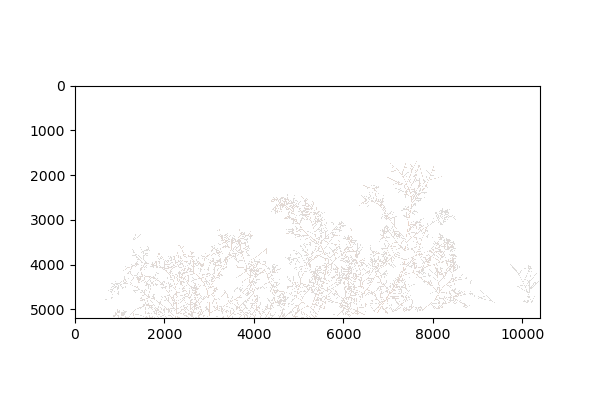

C:\Users\coren\AppData\Local\Temp\ipykernel_14076\2602457879.py:5: RuntimeWarning: invalid value encountered in divide
  unit_vector = vector / distance


In [109]:
regions = [[[0*5,0*5],[26000,52000]]]
for i,region in enumerate(regions):
    plot_region(region)

In [31]:
spatial_temporal_graph = exp.nx_graph[0]
weights = {(begin, end): LineString(data['pixel_list']).length * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "length")
weights, nodes_growing = get_growing_nodes(exp,index0,index1)

In [33]:
nodes_source = [node for node in nodes_growing if weights[node] / (np.pi * r0 ** 2) * 3600 > 10]


In [34]:
G0 = create_subgraph_by_attribute(spatial_temporal_graph, "post_hyperedge_activation", index0)
exp0 = make_exp(G0,folders,make_pixel_list = True)


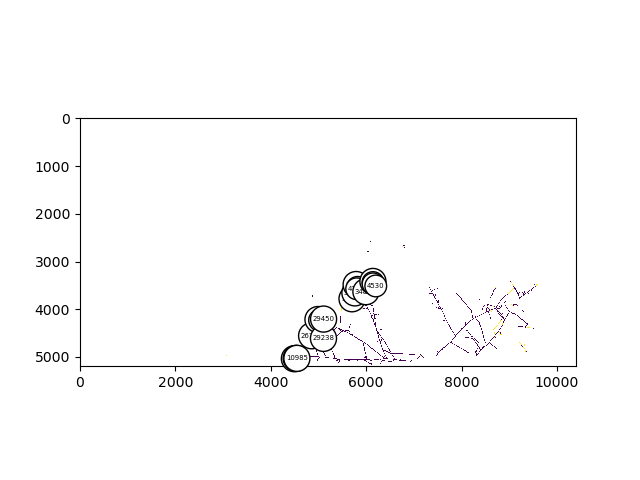

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: >,
 <function amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting.plot_edge_color_value_3.<locals>.<lambda>(x)>)

In [41]:

from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

from matplotlib import cm
vmax = 1
vmin = 0
t=0
region = [[0*5,0*5],[26000,52000]]

fig,ax = plt.subplots()
plot_edge_color_value_3(
    exp0,
    t,
    lambda edge : 1-(edge.get_attribute("activation",t)<=index0),
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    figax = (fig,ax),
    region = region,
    nodes = nodes_source
)


In [42]:
G0 = create_subgraph_by_attribute(spatial_temporal_graph, "activation", index0)
components = nx.connected_components(G0)
largest_component = max(components, key=len)
largest_component_graph = create_subgraph_from_nodelist(G0,largest_component)

exp1 = make_exp(largest_component_graph,folders)

In [43]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import *
nodes = get_all_nodes(exp1,0)
nodes_sink = [node for node in nodes if get_min_activation(largest_component_graph,node.label)<=index0]
nodes_sink = find_lowest_nodes(nodes_sink, 0,3)
nodes_source = [node for node in nodes_source if node in nodes]

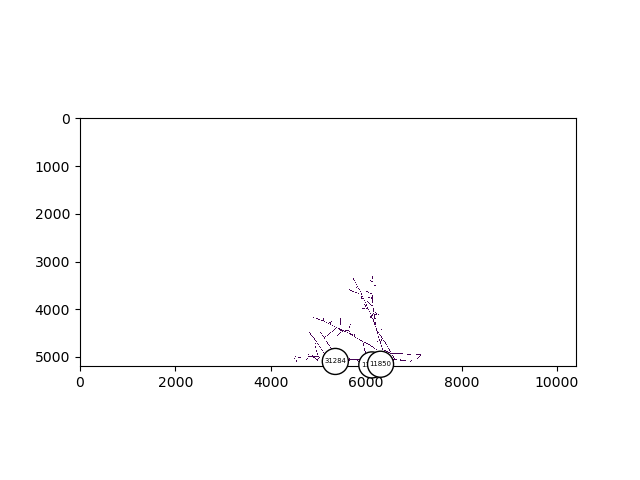

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: >,
 <function amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting.plot_edge_color_value_3.<locals>.<lambda>(x)>)

In [44]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

from matplotlib import cm

vmax = 1
vmin = 0
t=0

fig,ax = plt.subplots()
plot_edge_color_value_3(
    exp1,
    t,
    lambda edge : 1-(edge.get_attribute("activation",t)<=index0),
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    figax = (fig,ax),
    region = region,
    nodes = nodes_sink
)


In [46]:
add_flows_heaton2(exp1.nx_graph[0], nodes_source, nodes_sink, weights, index0)


KeyError: 'width'

(array([  2.,   0.,   0.,   0.,   4.,   7.,  26., 167.,  15.,  24.,  15.,
          9.,   4.,   5.,   4.,   1.,   0.,   2.,   0.,   1.]),
 array([-0.03405296, -0.02937378, -0.0246946 , -0.02001543, -0.01533625,
        -0.01065707, -0.00597789, -0.00129872,  0.00338046,  0.00805964,
         0.01273882,  0.01741799,  0.02209717,  0.02677635,  0.03145553,
         0.0361347 ,  0.04081388,  0.04549306,  0.05017224,  0.05485141,
         0.05953059]),
 <BarContainer object of 20 artists>)

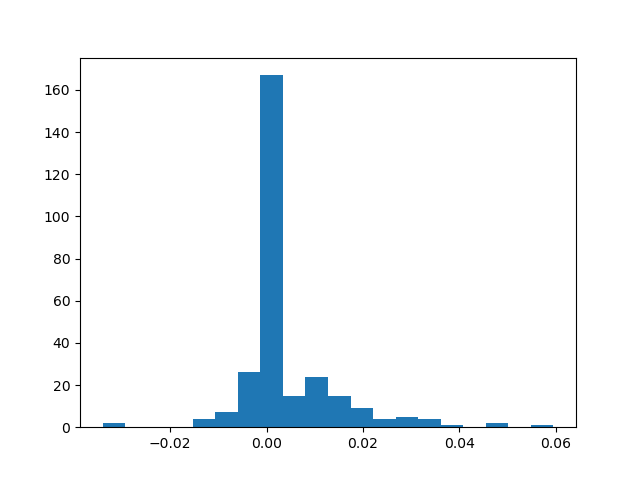

In [31]:
edges = get_all_edges(exp1,0)
speeds = [edge.get_attribute("QBC_net", 0)/(np.pi*edge.get_attribute("radius", 0)**2*3) for edge in edges]
fig,ax = plt.subplots()
ax.hist(speeds,20)


In [24]:
def add_flows(G,nodes_source,nodes_sink,weights,max_fraction = 0.1):
    for edge in G.edges:
        G[edge[0]][edge[1]]["radius"] = max(G[edge[0]][edge[1]]["width"] / 2, 1)
        # G[edge[0]][edge[1]]['v0'] = G[edge[0]][edge[1]]['QBC_net']/(2*np.pi*G[edge[0]][edge[1]]["radius"]**2)/max_fraction
        G[edge[0]][edge[1]]['v0'] = np.sign(G[edge[0]][edge[1]]['QBC_net'])*3
        
    DG = convert_to_directed(G)
    for node in (nodes_sink+nodes_source):
        DG.add_edge(node.label, "ground",length=0,radius=2,v0=0,Res=0,pot=0)  # Add edge back to the root
        
    ext_flows = {}
    A, b = build_matrix_system(DG, ext_flows)
    flows = solve_flows(A, b)
    edge_flows = {edge: flow for edge, flow in zip(DG.edges(), flows)}
    nx.set_edge_attributes(G, edge_flows, "water_flux")
    for edge in G.edges:
        G[edge[0]][edge[1]]["water_flux_abs"] = abs(G[edge[0]][edge[1]]["water_flux"])

        G[edge[0]][edge[1]]["speed"] = 2*G[edge[0]][edge[1]]["water_flux"] / (np.pi * G[edge[0]][edge[1]]["radius"] ** 2)-G[edge[0]][edge[1]]['v0']


In [25]:
add_flows(exp1.nx_graph[0],nodes_source,nodes_sink,weights)

found all cycles


Processing Cycles: 100%|█████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 3591.37it/s]


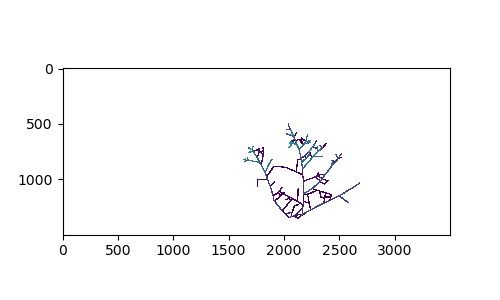

In [26]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *
from matplotlib import cm
downsizing = 5
t=0

fig, ax,f = plot_edge_color_value_3(
    exp1,
    t,
    lambda edge : abs(edge.get_attribute("speed",t)),
    cmap=cm.get_cmap("viridis", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    v_min = 0,
    v_max = 6,
    region = [[3750*5,4500*5],[5250*5,8000*5]]
    # nodes = non_zero

)

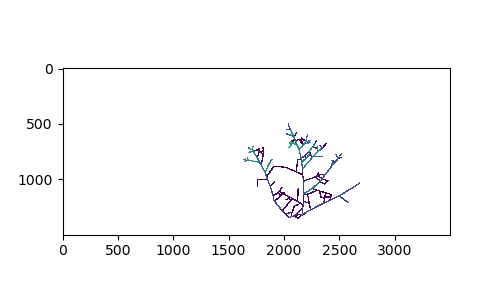

c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\transport_processing\high_mag_videos\temporal_graph_util.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  relative_flux = edge.get_attribute(attribute, 0) / edge.get_attribute("QBC_tot", 0)


In [27]:
region = [[3750*5,4500*5],[5250*5,8000*5]]
plot_region(exp1,region,"speed",5)

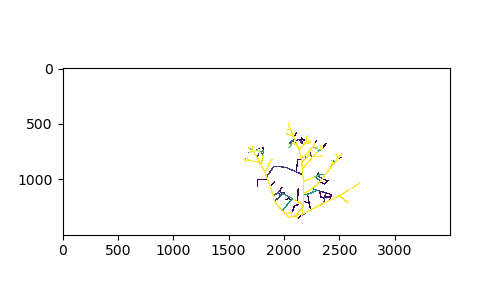

In [28]:
region = [[3750*5,4500*5],[5250*5,8000*5]]
plot_region(exp1,region,"water_flux",5)

(array([  8.,  15.,  19.,  20.,  17.,  10.,  31., 114.,   9.,   9.,   8.,
          6.,  10.,   2.,   2.,   2.,   1.,   1.,   1.,   1.]),
 array([-2.89595168, -2.4922892 , -2.08862671, -1.68496423, -1.28130175,
        -0.87763927, -0.47397678, -0.0703143 ,  0.33334818,  0.73701066,
         1.14067315,  1.54433563,  1.94799811,  2.35166059,  2.75532308,
         3.15898556,  3.56264804,  3.96631052,  4.36997301,  4.77363549,
         5.17729797]),
 <BarContainer object of 20 artists>)

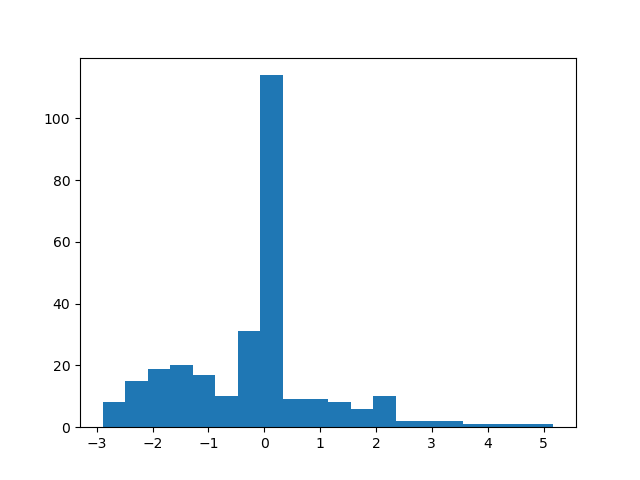

In [29]:
edges = get_all_edges(exp1,0)
speeds = [edge.get_attribute("speed", 0) for edge in edges]
fig,ax = plt.subplots()
ax.hist(speeds,20)
